In [86]:
%matplotlib inline
import numpy as np
import pandas as pd
import sqlite3
from scipy import stats, optimize, interpolate, integrate
from matplotlib import pyplot as plt

In [3]:
with sqlite3.connect(r'd:\data\scriptie\wrds.sqlite') as con:
    bla = pd.read_sql(
        """select strike_price/close strike, (best_bid+best_offer)/2/close option, rate rf, maturity/365. t
        from spx where date(observation) between date('2001-03-29') and date('2001-03-29')
        and maturity between 75 and 105--= (select min(maturity) from spx where date(observation) = date('2000-09-18'))
        order by strike""",
        con)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:600: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


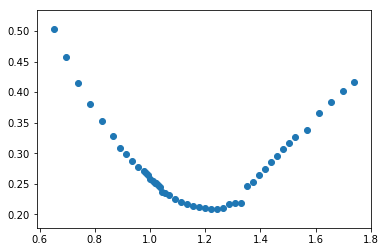

In [6]:
bla['imp_vol'] = bla.apply(lambda row: optimize.minimize_scalar(C(row), method='bounded', bounds=[0,1], tol=1e-12).x, axis=1)
# optimize.minimize_scalar(C(bla.iloc[1,:]), method='golden', tol=1e-12)
plt.scatter(bla.strike, bla.imp_vol)
# bla

In [39]:
bla['lb_vol'] = bla.apply(lambda row: optimize.minimize_scalar(get_fit(row, sigmaM_lb), method='bounded', bounds=[0,1], options={'xatol':1e-5}).x, axis=1)
bla['m_vol'] = bla.apply(lambda row: optimize.minimize_scalar(get_fit(row, sigmaM), method='bounded', bounds=[0,1], options={'xatol':1e-5}).x, axis=1)
bla['ub_vol'] = bla.apply(lambda row: optimize.minimize_scalar(get_fit(row, sigmaM_ub), method='bounded', bounds=[0,1], options={'xatol':1e-5}).x, axis=1)

''

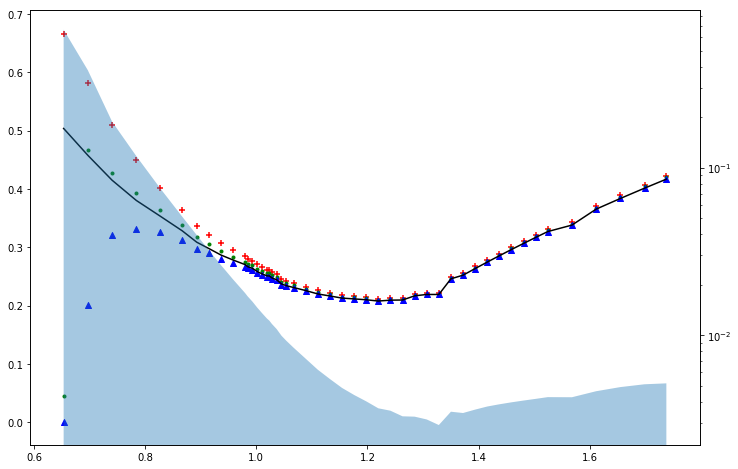

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
axt = ax.twinx()
axt.fill_between(bla.strike, 0, bla.lb_vol - bla.ub_vol, alpha=.4)
axt.set_yscale('log')

ax.scatter(bla.strike, bla.lb_vol, marker='+', c='r')
ax.scatter(bla.strike, bla.m_vol, marker='.', c='g')
ax.scatter(bla.strike, bla.ub_vol, marker='^', c='b')
ax.plot(bla.strike, bla.imp_vol, 'k')
;

In [38]:
N = int(1e5)
W = np.random.normal(size=(2, N))
bar = lambda k,x: np.sqrt(k**2 - x**2)
# Sh= 1
r = .7
qS = -0.008
qV = -0.02
sV = .2
sS = .23
Sh = 2*qS/sS

gamma_lb = - np.sqrt(Sh**2 - (qS/sS)**2)
sigmaM_lb = np.array([qS/sS, gamma_lb])

gamma_ub = + np.sqrt(Sh**2 - (qS/sS)**2)
sigmaM_ub = np.array([qS/sS, gamma_ub])

sigmaM = np.array([qS/sS, 0])

def get_fit(row, sigmaM):
    ks, cs, t, rf = row.loc[['strike', 'option', 't', 'rf']].values
    st = np.sqrt(t)
    def fit(sV):
        muM = -.5 * sigmaM @ sigmaM.T*t
        M = np.exp(muM + st*sigmaM @ W)

        sigmaV = np.array([r, bar(1,r)])*sV*st
        muV = -qV*st -.5 * sigmaV @ sigmaV.T
        V = np.exp(muV + sigmaV @ W)
        
        return (np.mean(M*np.maximum(0, V-ks)) - cs)**2
    return fit

optimize.minimize_scalar(get_fit(bla.iloc[0,:], sigmaM_ub), method='bounded', bounds=[0,1])
# optimize.minimize_scalar(get_fit_l(bla.iloc[0,:]))

     fun: 4.5766993069282077e-08
 message: 'Solution found.'
    nfev: 27
  status: 0
 success: True
       x: 5.1619371759950608e-06

In [117]:
def _d_es(a):
    return lambda x: -x/a*np.exp(-x**2/2)/np.sqrt(2*np.pi)
es = lambda a: integrate.quad(_d_es(a), -float('inf'), stats.norm.ppf(a))[0]

In [38]:
N = int(1e5)
W = np.random.normal(size=(2, N))
bar = lambda k,x: np.sqrt(k**2 - x**2)
# Sh= 1
r = .7
qS = -0.008
qV = -0.02
sV = .2
sS = .23
Sh = 2*qS/sS

gamma_lb = - np.sqrt(Sh**2 - (qS/sS)**2)
sigmaM_lb = np.array([qS/sS, gamma_lb])

gamma_ub = + np.sqrt(Sh**2 - (qS/sS)**2)
sigmaM_ub = np.array([qS/sS, gamma_ub])

sigmaM = np.array([qS/sS, 0])

def get_fit(row, sigmaM):
    ks, cs, t, rf = row.loc[['strike', 'option', 't', 'rf']].values
    st = np.sqrt(t)
    def fit(sV):
        muM = -.5 * sigmaM @ sigmaM.T*t
        M = np.exp(muM + st*sigmaM @ W)

        sigmaV = np.array([r, bar(1,r)])*sV*st
        muV = -qV*st -.5 * sigmaV @ sigmaV.T
        V = np.exp(muV + sigmaV @ W)
        
        return (np.mean(M*np.maximum(0, V-ks)) - cs)**2
    return fit

optimize.minimize_scalar(get_fit(bla.iloc[0,:], sigmaM_ub), method='bounded', bounds=[0,1])
# optimize.minimize_scalar(get_fit_l(bla.iloc[0,:]))

     fun: 4.5766993069282077e-08
 message: 'Solution found.'
    nfev: 27
  status: 0
 success: True
       x: 5.1619371759950608e-06

In [541]:
with sqlite3.connect(r'd:\data\scriptie\wrds.sqlite') as con:
    df = pd.read_sql('select observation, close from spx_options group by observation, close', con, index_col='observation')

In [548]:
df = df.shift(1).div(df).squeeze()

In [555]:
df.std()

0.012580621356582356

In [549]:
N = int(1e5)
W = np.random.normal(size=(2, N))
bar = lambda k,x: np.sqrt(k**2 - x**2)
Sh= .3
r = .5
qS = -.01
qV = -.01
sV = .2
sS = df.std()
# Sh = -2*qS/sS

def get_fit_l(row):
    ks, cs, t, rf, sS = row.loc[['strike', 'option', 't', 'rf', 'imp_vol']].values
    Sh = -qS/sS*5
    st = np.sqrt(t)
    def fit_l(sV):
        if Sh**2 < (r*sV + qS)**2:
            return 1e10
        gamma_lb = - np.sqrt(Sh**2 - (r*sV + qS)**2) - bar(1,r)*sV

        sigmaM_lb = np.array([qS/sS, gamma_lb])*st
        muM_lb = -.5 * sigmaM_lb @ sigmaM_lb.T

        sigmaV = np.array([sV*r, sV*bar(1,r)])*st
        muV = -qV*st -.5 * sigmaV @ sigmaV.T

        V = np.exp(muV + sigmaV @ W)
        M_lb = np.exp(muM_lb + sigmaM_lb @ W)
        
        return (np.mean(M_lb*np.maximum(0, V-ks)) - cs)**2
    return fit_l

,close
observation,
2000-09-01 00:00:00,NaN
2000-09-05 00:00:00,1.009084
2000-09-06 00:00:00,1.009938
2000-09-07 00:00:00,0.993171
2000-09-08 00:00:00,1.005360
2000-09-11 00:00:00,1.003519
2000-09-12 00:00:00,1.004906
2000-09-13 00:00:00,0.998034
2000-09-14 00:00:00,1.002728


In [5]:
def C(row):
    ks, cs, t, r = row.loc[['strike', 'option', 't', 'rf']].values
    def blep(sigma):
        d1 = ( sigma/2 + r/sigma )*np.sqrt(t) - np.log(ks)/np.sqrt(t)/sigma
        return ( stats.norm.cdf(d1) - ks*np.exp(-r*t)*stats.norm.cdf(d1-sigma*np.sqrt(t)) - cs )**2
    return blep
    # TODO
    
    # HIERO HIER WAS JE HIERO KIJK DAN
    
# C = lambda s, t: lambda sigma: s*(stats.norm.cdf(sigma/2*np.sqrt(t)) - stats.norm.cdf(-sigma/2*np.sqrt(t)))
# L = lambda t, cs: lambda sigma: ( 2*stats.norm.cdf(sigma/2*np.sqrt(t)) - 1 - cs)**2

In [39]:
options = pd.read_csv('options.csv').drop(['secid', 'index_flag', 'issue_type'], axis=1)
zerocd = pd.read_csv('zero_coupon_dividend.csv')
options.date = pd.to_datetime(options.date, format='%Y%m%d')
zerocd.date = pd.to_datetime(zerocd.date, format='%Y%m%d')
options['premiumfrac'] = options.premium / options.forward_price
options['T'] = options.days/364

In [31]:
options.zerocd = np.log(options.zerocd.div(100).add(1))
calls = options.loc[options.cp_flag == 'C', :]
puts = options.loc[options.cp_flag == 'P', :]

In [37]:
# options['my_imp_vol'] = options.apply(lambda row: optimize.minimize_scalar(Crow).x, axis=1)
optimize.minimize_scalar(C( options.loc[5662, :] ))
# options.loc[5662, ['T', 'premiumfrac']].values

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


     fun: 1.6020826735645903e-24
    nfev: 12
     nit: 11
 success: True
       x: 0.18237500122151623

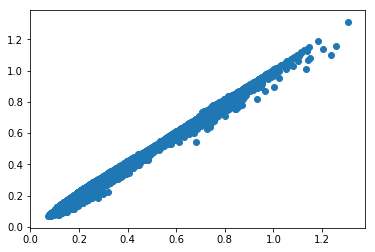

In [86]:
# options.merge(sec, on=['date', 'ticker'])
# sec.loc[sec.volume > 0, :]
options.loc[options.date=='2006-05-19']
# sec.loc[sec.date == '2006-05-19']
# _x = np.arange(-3,3,.01)
# plt.plot(_x, stats.norm.cdf(_x) - stats.norm.cdf(-_x), 'b')
# plt.plot(_x, 2*stats.norm.cdf(_x)-1, 'k')
plt.scatter(options.my_imp_vol, options.impl_volatility)